<a href="https://colab.research.google.com/github/sashapff/bioinformatics-algorithms/blob/master/HW_2_kNN_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [108]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.neighbors import KDTree

Mounted at /content/drive


### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [ ]:
CANCER_DATA_PATH = '/content/drive/My Drive/bioinf/ml/hw2_data/cancer.csv'
SPAM_DATA_PATH = '/content/drive/My Drive/bioinf/ml/hw2_data/spam.csv'

In [ ]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    dataset = pd.read_csv(path_to_csv)
    X = dataset.drop("label", axis=1)
    y = dataset.label.map({'B': 0, 'M': 1})
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    dataset = pd.read_csv(path_to_csv)
    X = dataset.drop("label", axis=1)
    y = dataset.label
    return X, y

In [ ]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [ ]:
def train_test_split(X, y, ratio=0.9):
    # Возвращает X_train, X_test, y_train, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=1-ratio)
    return X_train, y_train, X_test, y_test

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [ ]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    precision, recall, accuracy = [], [], []
    for c in [0, 1]:
        tp = int(((y_pred == c) & (y_true == c)).sum())
        tn = int(((y_pred != c) & (y_true != c)).sum())
        fp = int(((y_pred == c) & (y_true != c)).sum())
        fn = int(((y_pred != c) & (y_true == c)).sum())
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        accuracy.append((tp + tn) / (tp + tn + fp + fn))
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [ ]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [ ]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [ ]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.kd_tree = KDTree(self.X_train, leaf_size=self.leaf_size)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее колич[ество соседей
        predictions = []
        classes = self.y_train.unique()
        dist, ind = self.kd_tree.query(X, k=self.n_neighbors)
        for i in ind:
            prediction = []
            for c in classes:
                prediction.append((self.y_train[self.X_train.index[i]] == c).sum() / self.n_neighbors)
            predictions.append(prediction)
        predictions = np.array(predictions)
        return predictions
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных

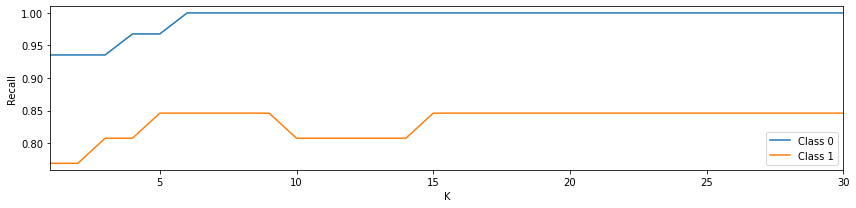

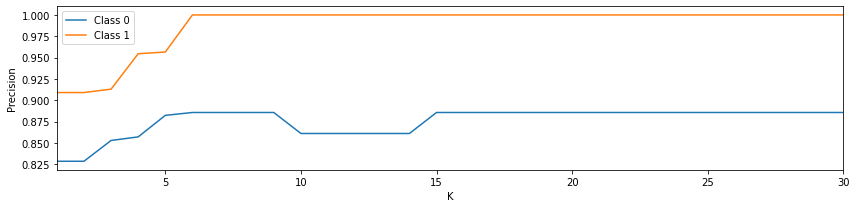

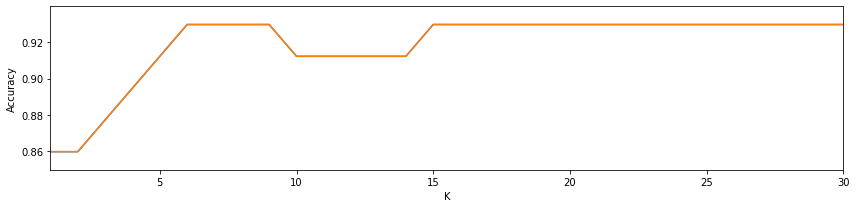

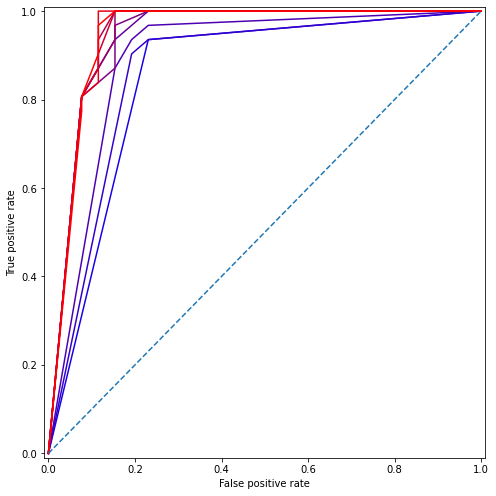

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

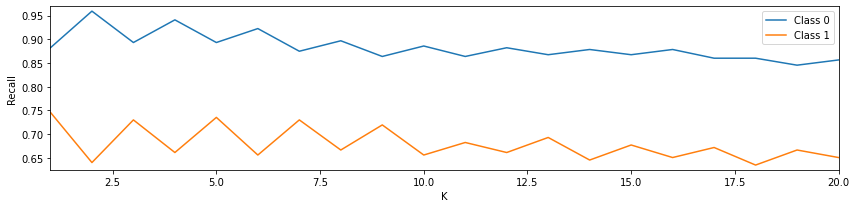

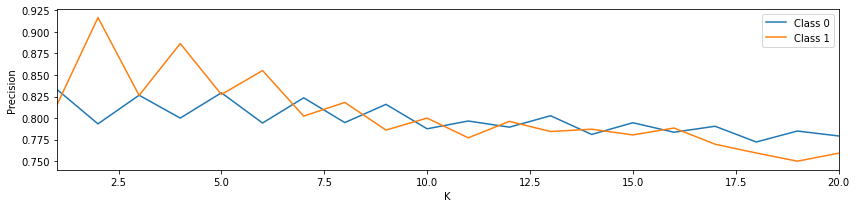

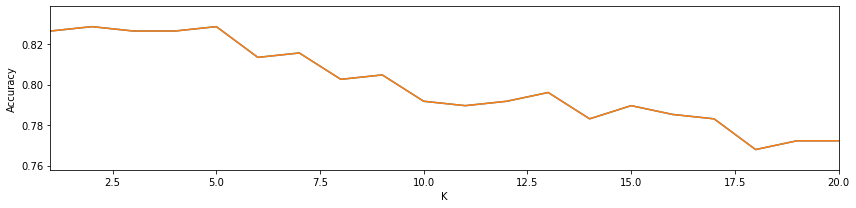

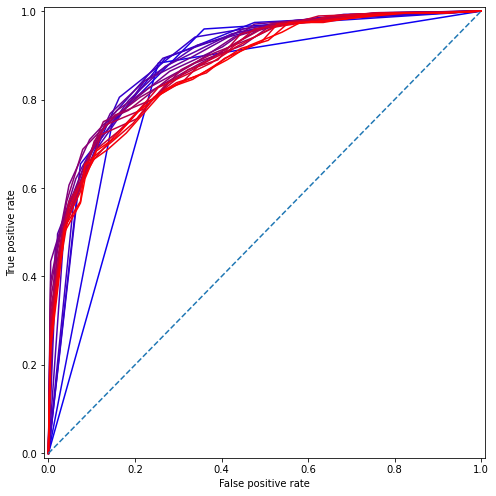

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

Для датасета с данными по раку я бы выбрала k не менее 5, так как именно после такого значения все три метрики качества начинают показывать высокие значения. В датасете приведены данные для доброкачественных и злокачественных опухолей, нам важно ошибаться и не классифицировать злокачетсвенные как доброкачественные, метрика recall будет наиболее сильно отражать такие ошибки, так как в формуле учитывается false negative (для класса -- злокачественная опухоль).

Для второго датасета по спаму я бы выбрала k наоборот не больше 5, так как для больших точность падает. Для спама наоборот важно не классифицировать не спам как спам, то есть хотим минимизировать false positive (для класса -- неспам). Метрика precision учитывает значение false positive и разумнее использовать ее.

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from sklearn.preprocessing import normalize

In [3]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

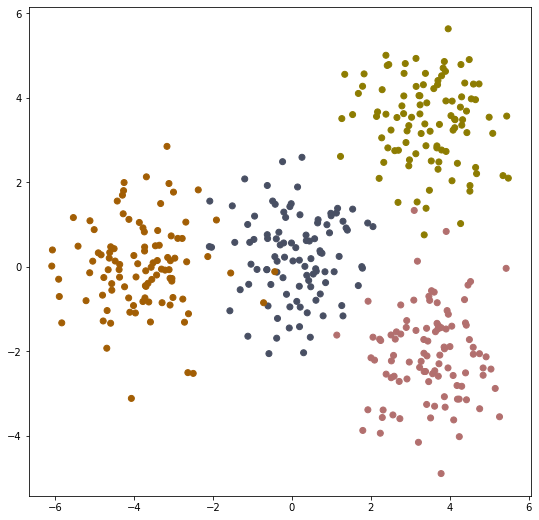

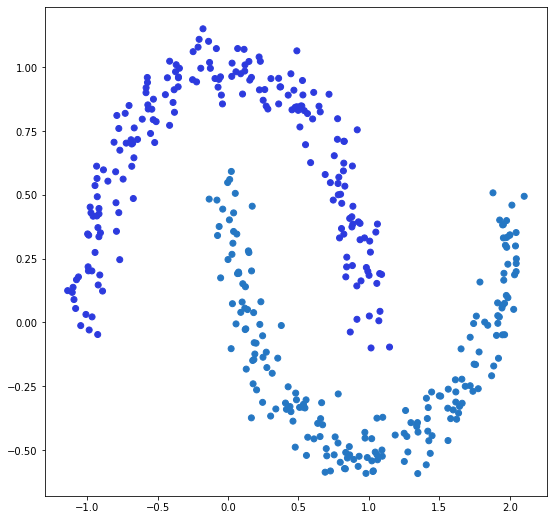

In [51]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [34]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter

    def get_cluster(self, p):
        return ((p - self.centroids) ** 2).sum(axis=1).argmin()
        
    def fit(self, X, y=None, eps=1e-6):
        if self.init == "random":
            self.centroids = np.array([[random.uniform(X.min(axis=0)[0], X.max(axis=0)[0]), 
                                        random.uniform(X.min(axis=0)[1], X.max(axis=0)[1])] for _ in range (self.n_clusters)])
        elif self.init == "sample":
            self.centroids = np.array(X[np.random.choice(X.shape[0], size=self.n_clusters, replace=False)])
        elif self.init == "k-means++":
            self.centroids = np.array(X[np.random.choice(X.shape[0], 1)])
            M = np.zeros(X.shape[0])
            for step in range(self.n_clusters - 1):
                for i in range(X.shape[0]):
                    M[i] = 10**10
                    for j in range(self.centroids.shape[0]):
                        M[i] = min(M[i], ((X[i] - self.centroids[j]) ** 2).sum())
                new_centroid = np.random.choice(a=X.shape[0], p=M / M.sum())
                self.centroids = np.append(self.centroids, X[[new_centroid]])
        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]
            for i in range(X.shape[0]):
                clusters[self.get_cluster(X[i])].append(i)

            stop = True
            for i in range(self.n_clusters):
                new_centroid = np.average(X[clusters[i]], axis=0)
                if ((new_centroid - self.centroids[i]) ** 2).sum() > eps ** 2:
                    stop = False
                self.centroids[i] = new_centroid
            if stop:
                break
   
    def predict(self, X):
        predictions = np.zeros(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            predictions[i] = self.get_cluster(X[i])
        return predictions

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

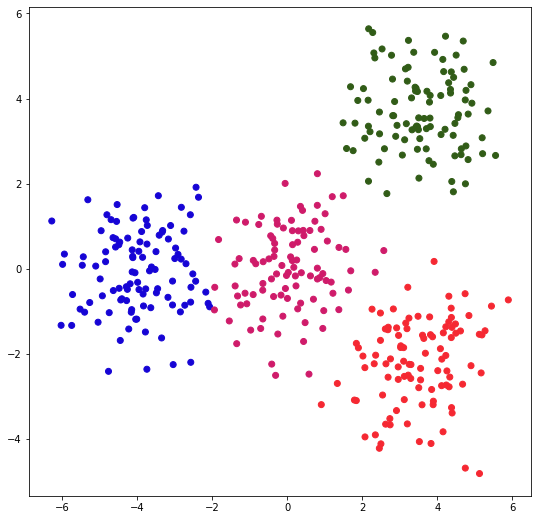

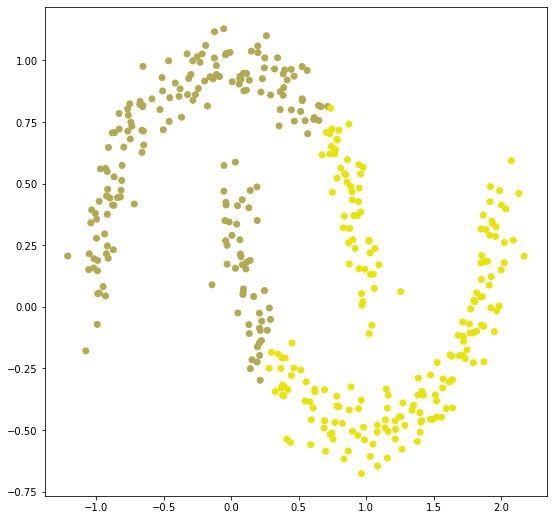

In [44]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [39]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric

    def dfs(self, u, cluster):
            self.clusters[u] = cluster
            neighbors = self.kd_tree.query_radius(self.X[u].reshape(1, -1), self.eps)[0]
            if neighbors.shape[0] > self.min_samples:
                for v in neighbors:
                    if self.clusters[v] == -1:
                        self.dfs(v, cluster)
        
    def fit_predict(self, X, y=None):
        self.X = X
        self.y = y
        self.kd_tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        self.clusters = [-1 for _ in range(X.shape[0])]
        cluster = 0
        for i in range(X.shape[0]):
            if self.clusters[i] == -1:
                self.dfs(i, cluster)
                cluster += 1
        return self.clusters

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

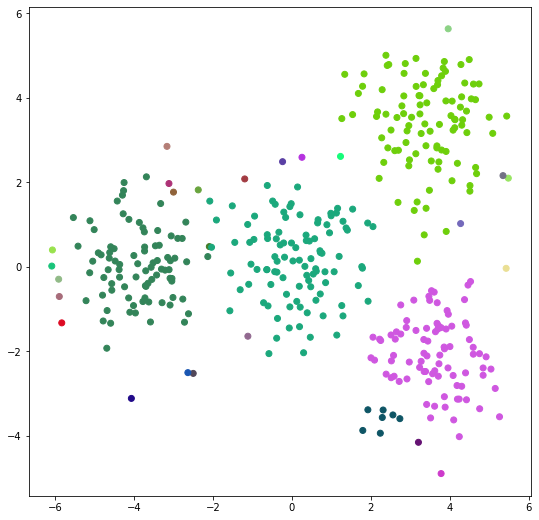

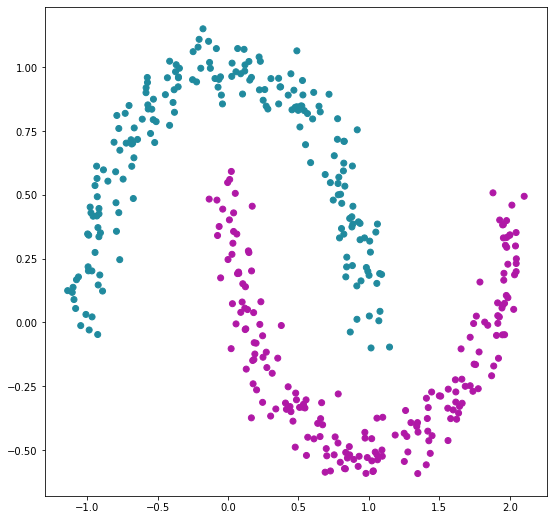

In [59]:
dbscan = DBScan(eps=0.65, min_samples=4)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.25)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

На мой взгляд с задачей кластеризации лучше справился DBSCAN, он различил все четыре кластера из первого датасета и идеально разделил на кластеры во втором случае (подбирала гиперпараметр eps и min_samples). Для второго датасета это не удивительно, так как алгоритм смотрит на соседние точки и добавляет их в кластер. 

Davies-Bouldin index нужно стараться минимизировать, в то время как Silhouette score максимизировать.

*После исправления ошибки в k-means алгоритм стал различать все 4 кластера первого датасета, a DBSCAN кластеризует много точек как выбросы, выделяя их в отдельные кластеры, это не всегда хорошо, хоть и бывает полезно. Второй датасет k-means кластеризует неверно, а DBSCAN справляется хорошо и правильно.*

*Основываясь на значениях метрик видно, что для первого датасета значения соотносятся с нашими представлениями о том, что k-means кластеризовал чуть лучше. Второй датасет имеет нетривиальную структуру и метрики для него читаются не совсем корректно и не отражают качество кластеризации, по ним лучше не сравнивать.*


In [32]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [87]:
kmeans_1 = KMeans(n_clusters=4)
kmeans_1.fit(X_1)
labels_kmeans_1 = kmeans_1.predict(X_1)

dbscan_1 = DBScan(eps=0.75, min_samples=5)
labels_dbscan_1 = dbscan_1.fit_predict(X_1)

kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(X_2)
labels_kmeans_2 = kmeans_2.predict(X_2)

dbscan_2 = DBScan(eps=0.25)
labels_dbscan_2 = dbscan_2.fit_predict(X_2)

print('Dataset 1')

print('\tDavies-Bouldin index')
print('\t\tK-means:', davies_bouldin_score(X_1, labels_kmeans_1))
print('\t\tDBSCAN:', davies_bouldin_score(X_1, labels_dbscan_1))


print('\tSilhouette score')
print('\t\tK-means:', silhouette_score(X_1, labels_kmeans_1))
print('\t\tDBSCAN:', silhouette_score(X_1, labels_dbscan_1))

print('Dataset 2')

print('\tDavies-Bouldin index')
print('\t\tK-means:', davies_bouldin_score(X_2, labels_kmeans_2))
print('\t\tDBSCAN:', davies_bouldin_score(X_2, labels_dbscan_2))


print('\tSilhouette score')
print('\t\tK-means:', silhouette_score(X_2, labels_kmeans_2))
print('\t\tDBSCAN:', silhouette_score(X_2, labels_dbscan_2))

Dataset 1
	Davies-Bouldin index
		K-means: 0.5741399151979818
		DBSCAN: 0.6262186643098477
	Silhouette score
		K-means: 0.5751633609107542
		DBSCAN: -0.1446104312553858
Dataset 2
	Davies-Bouldin index
		K-means: 0.7778913510302744
		DBSCAN: 1.1758154505242902
	Silhouette score
		K-means: 0.48922978404901374
		DBSCAN: 0.3212724129708249


### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [ ]:
# YOUR_CODE